## FACET2e BMAD simple example

You will need to install pytao, BMAD, and openpmd-beamphysics (as well as standard libraries like numpy, matplotlib and pandas)

 conda install -c conda-forge bmad
 conda install -c conda-forge pytao, openpmd-beamphysics

In [3]:
from pytao import Tao
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import re
import io
from os import path,environ
import pandas as pd

from pmd_beamphysics import ParticleGroup
from pmd_beamphysics.statistics import resample_particles

#needed for lattice_init
%env FACET2_LATTICE /u/ar/dcesar/notebooks/facet_bmad
print('Make sure enviornment was set!:  ', environ['FACET2_LATTICE']) 
#

env: FACET2_LATTICE=/u/ar/dcesar/notebooks/facet_bmad
Make sure enviornment was set!:   /u/ar/dcesar/notebooks/facet_bmad


In [4]:
colorlist=['#982649', '#6BCAE2', '#72bda3', '#ed6a5a', '#533a71']
colorlist2=['#E2836A','#6a7ee2','#74e26a']

def floorplan_sorter(ele):
    """
    ele is an element of a pandas dictionary made from the bmad floorplan (made to look like an elegant floorplan from my "elegant_helpers" file). This sorter parses the columns to make a "patch" for plotting purposes. See floorplan_patches().
    """
    if ele['ds']==0:
        ele['ds']=0.05
    s0=float(ele['s'])-float(ele['ds'])
    x=float(ele['X'])*2-0.5
    
    if (re.search('DRIF',ele.ElementType.upper())!=None)|(ele.ElementType.upper()=='MARK'):
        patchColor=None
        patch=None
    elif (re.search('BEND',ele.ElementType.upper())!=None)|(re.search('KICK',ele.ElementType.upper())!=None):
        patchColor='r'
        patch=mpatches.Rectangle(xy=(s0,x),width=float(ele['ds']),height=1,color=patchColor,lw=0,ls=None)
    elif re.search('XL',ele.ElementName.upper())!=None:
        patchColor=colorlist2[1]
        patch=mpatches.Rectangle(xy=(s0,x),width=float(ele['ds']),height=1,color=patchColor,lw=0,ls=None)
    elif 'QUAD' in ele.ElementType.upper():
        patchColor=colorlist[2]
        patch=mpatches.Rectangle(xy=(s0,x),width=float(ele['ds']),height=1,color=patchColor,lw=0,ls=None)
    elif 'SEXT' in ele.ElementType.upper():
        patchColor="#204337"
        patch=mpatches.Rectangle(xy=(s0,x),width=float(ele['ds']),height=1,color=patchColor,lw=0,ls=None)
    elif 'RFCW' in ele.ElementType.upper() or 'CAV' in ele.ElementType.upper():
        string_lst=['L3_10_50','L3_10_25','L2_10_25','L2_10_50','X1_Xband','L1_10_25','L1_9_25','L1_9_50'] #nonzero voltage
        if re.findall(r"(?=("+'|'.join(string_lst)+r"))",ele.ElementName)!=None:
            patchColor="#CD7F32"
            patch=mpatches.Rectangle(xy=(s0,x),width=float(ele['ds']),height=0.5,color=patchColor,lw=0,ls=None)
    elif re.search('^UM',ele.ElementName)!=None:
        patchColor=colorlist[1]
        patch=mpatches.Rectangle(xy=(s0,x),width=float(ele['ds']),height=1,color=patchColor,lw=0,ls=None)
    else:
        patchColor=None
        patch=None
        
    return patch

def floorplan_patches(floorplan,zbounds=None):
    """
    This function returns a list of patches to be plotted (patches) and a list of patches for the legend (leg_patches). If zbounds=[zmin,zmax] is given then the plot is restricted to the bounds. 
    
    Useage:
    
    fp=SDDS(0)
    fp.load(LCLS2scS.flr)
    __,floorplan=sdds2pd(fp)
    patches,leg_patches=flooplan_patches(floorplan,[3425,3750])
    """
    if zbounds==None:
        zbounds=[flooplan['s'].min(),flooplan['s'].max()]
    sFloor=floorplan.s.astype(dtype=float);
    sFloor=sFloor.values
    ii=0;
    patches=[];
    for index, ele in (floorplan.iloc[(sFloor>zbounds[0])&(sFloor<zbounds[1])]).iterrows():
        patches.append(floorplan_sorter(ele))
    
    quad_patch = mpatches.Patch(color=colorlist[2], label='Quad')
    sext_patch = mpatches.Patch(color="#204337", label='Linac')
    bend_patch = mpatches.Patch(color='red', label='Bend')
    leg_patches=[quad_patch,sext_patch,bend_patch];
    return patches,leg_patches

In [5]:
def floorplan_plot(ax_fp,floorplan,zmin=0,zmax=2000):  
    """
    This function plots "patches" for basic elements in the lattice. This can help identify what you're looking at in a "z-plot".
    """
    
    patches,leg_patches=floorplan_patches(floorplan,[zmin,zmax])

    for p in patches:
        if p!=None:
            ax_fp.add_patch(p)

    ax_fp.plot((zmin,zmax),(0,0),'k',alpha=0.0)
    ax_fp.tick_params(axis='x',direction='out',length=15,width=6,color='k',bottom=True)
    plt.yticks([])
    #ax_fp.set_ylim([-3,1])
    ax_fp.set_xlim([zmin,zmax])
    return ax_fp
    
def format_longitudinal_plot(fig):
    """
    This function helps format a "z-plot" by providing axes for the main plot and for the a floorplan_plot. It also plots the floorplan.
    """
    outer_grid=fig.add_gridspec(5,1,hspace=0)
    ax=fig.add_subplot(outer_grid[0:4,:])
    ax_fp=fig.add_subplot(outer_grid[4,:], sharex = ax)
    floorplan_plot(ax_fp,floorplan)
    plt.sca(ax)
    
    return ax, ax_fp 

# Start tao

In [6]:
tao=Tao('-init {:s}/bmad/models/f2_elec/tao.init -noplot'.format(environ['FACET2_LATTICE'])) 

## Plot single particle twiss

In [107]:
elements=tao.lat_ele_list();
#tao.lat_list(elements[0],'ElementType')
tao.ele_gen_attribs(elements[0])

{'INHERIT_FROM_FORK': False,
 'CMAT_11': 0.0,
 'units#CMAT_11': '',
 'CMAT_12': 0.0,
 'units#CMAT_12': '',
 'CMAT_21': 0.0,
 'units#CMAT_21': '',
 'CMAT_22': 0.0,
 'units#CMAT_22': '',
 'P0C_START': 5978200.40422692,
 'units#P0C_START': 'eV',
 'E_TOT_START': 6000000.0,
 'units#E_TOT_START': 'eV',
 'P0C': 5978200.40422692,
 'units#P0C': 'eV',
 'E_TOT': 6000000.0,
 'units#E_TOT': 'eV'}

In [110]:
?tao.lat_list

Signature:
tao.lat_list(
    elements,
    who,
    *,
    ix_uni='',
    ix_branch='',
    which='model',
    flags='-array_out -track_only',
    verbose=False,
    as_dict=True,
    raises=True,
)
Docstring:
Output list of parameters at ends of lattice elements

Parameters
----------
elements
who
ix_uni : optional
ix_branch : optional
which : default=model
flags : optional, default=-array_out -track_only

Returns
-------
string_list
    if ('-array_out' not in flags) or (who in ['ele.name'])
integer_array
    if '-array_out' in flags and who in ['orbit.state', 'ele.ix_ele']
real_array
    if ('-array_out' in flags) or ('real:' in who) 

Notes
-----
Command syntax:
  python lat_list {flags} {ix_uni}@{ix_branch}>>{elements}|{which} {who}

where:
 Optional {flags} are:
  -no_slaves : If present, multipass_slave and super_slave elements will not be matched to.
  -track_only : If present, lord elements will not be matched to.
  -index_order : If present, order elements by element index in

In [7]:
floorplan=pd.read_csv(io.StringIO('\n'.join(tao.show('lat -all -floor_coords -tracking_elements')[3:-5])), sep="[\s\n]+",engine='python',
            names=['Index','ElementName','ElementType','s','ds','X','Y','Z','Theta','Phi','Psi'])
floorplan.drop(0,inplace=True)
floorplan[::25].head(7)

,Index,ElementName,ElementType,s,ds,X,Y,Z,Theta,Phi,Psi
1,1,DL00,Drift,-0.86905,-0.86905,10.69357,0.0,1001.56206,-0.61087,0.0,0.0
26,26,DL01H,Drift,1.03220,0.09012,9.60305,0.0,1003.11948,-0.61087,0.0,0.0
51,51,L0BF#2,Lcavity,5.25643,0.33713,7.18014,0.0,1006.57976,-0.61087,0.0,0.0
76,76,QE10441,Quadrupole,8.50702,0.10800,5.31568,0.0,1009.24248,-0.61087,0.0,0.0
101,101,QE10511#1,Quadrupole,11.14124,0.05400,3.80475,0.0,1011.40031,-0.61087,0.0,0.0
126,126,BPM10581,Monitor,14.39777,0.00000,1.93688,0.0,1014.06791,-0.61087,0.0,0.0
151,151,QB10731#1,Quadrupole,17.73019,0.05340,0.26540,0.0,1016.91774,-0.30543,0.0,0.0


In [87]:
floorplan[floorplan.s<9.0].head(60)

,Index,ElementName,ElementType,s,ds,X,Y,Z,Theta,Phi,Psi
1,1,DL00,Drift,-0.86905,-0.86905,10.69357,0.0,1001.56206,-0.61087,0.0,0.0
2,2,LOADLOCKF,Drift,0.00000,0.86905,10.19510,0.0,1002.27394,-0.61087,0.0,0.0
3,3,BEGINJ,Marker,0.00000,0.00000,10.19510,0.0,1002.27394,-0.61087,0.0,0.0
4,4,SOL10111,Solenoid,0.00000,0.00000,10.19510,0.0,1002.27394,-0.61087,0.0,0.0
5,5,CATHODEF,Instrument,0.00000,0.00000,10.19510,0.0,1002.27394,-0.61087,0.0,0.0
6,6,DL01A,Drift,0.09729,0.09729,10.13930,0.0,1002.35364,-0.61087,0.0,0.0
7,7,SOL10121#1,Solenoid,0.19729,0.10000,10.08194,0.0,1002.43556,-0.61087,0.0,0.0
8,8,YC10122,Vkicker,0.19729,0.00000,10.08194,0.0,1002.43556,-0.61087,0.0,0.0
9,9,XC10121,Hkicker,0.19729,0.00000,10.08194,0.0,1002.43556,-0.61087,0.0,0.0
10,10,SQ10122,Multipole,0.19729,0.00000,10.08194,0.0,1002.43556,-0.61087,0.0,0.0


In [8]:
floorplan[floorplan.ElementName.str.contains('IP')][::1].head(5)

,Index,ElementName,ElementType,s,ds,X,Y,Z,Theta,Phi,Psi
1511,1511,IPOTR1P,Monitor,994.63892,0.00000,-0.0,-0.0,1993.74,0.0,0.0,0.0
1513,1513,IPOTR1,Monitor,994.72892,0.00000,-0.0,-0.0,1993.83,0.0,0.0,0.0
1516,1516,MIP,Marker,994.76892,0.00000,-0.0,-0.0,1993.87,0.0,0.0,0.0
1518,1518,IPWS1,Monitor,994.80892,0.00000,-0.0,-0.0,1993.91,0.0,0.0,0.0
1522,1522,IPOTR2,Monitor,995.98892,0.00000,-0.0,-0.0,1995.09,0.0,0.0,0.0


In [91]:
floorplan[floorplan.ElementType.str.contains('cavity')][::1].head(25)

,Index,ElementName,ElementType,s,ds,X,Y,Z,Theta,Phi,Psi
27,27,L0AF#1,Lcavity,1.09085,0.05865,9.56942,0.0,1003.16752,-0.61087,0.0,0.0
29,29,L0AF#2,Lcavity,1.93952,0.84867,9.08264,0.0,1003.86271,-0.61087,0.0,0.0
32,32,L0AF#3,Lcavity,2.57983,0.64030,8.71537,0.0,1004.38721,-0.61087,0.0,0.0
34,34,L0AF#4,Lcavity,4.06653,1.48670,7.86264,0.0,1005.60505,-0.61087,0.0,0.0
36,36,L0AF#5,Lcavity,4.12745,0.06092,7.82770,0.0,1005.65495,-0.61087,0.0,0.0
49,49,L0BF#1,Lcavity,4.91930,0.05865,7.37351,0.0,1006.30360,-0.61087,0.0,0.0
51,51,L0BF#2,Lcavity,5.25643,0.33713,7.18014,0.0,1006.57976,-0.61087,0.0,0.0
54,54,L0BF#3,Lcavity,6.40828,1.15185,6.51947,0.0,1007.52330,-0.61087,0.0,0.0
56,56,L0BF#4,Lcavity,7.55984,1.15156,5.85896,0.0,1008.46660,-0.61087,0.0,0.0
59,59,L0BF#5,Lcavity,7.89498,0.33514,5.66673,0.0,1008.74113,-0.61087,0.0,0.0


In [90]:
tao.ele_gen_attribs('K11_2C#1')

{'L': 1.52205,
 'units#L': 'm',
 'TILT': 0.0,
 'units#TILT': 'rad',
 'RF_FREQUENCY': 2856000000.0,
 'units#RF_FREQUENCY': 'Hz',
 'RF_WAVELENGTH': 0.104969348039216,
 'units#RF_WAVELENGTH': 'm',
 'GRADIENT': 14828276.4417701,
 'units#GRADIENT': 'eV/m',
 'GRADIENT_ERR': 0.0,
 'units#GRADIENT_ERR': 'eV/m',
 'VOLTAGE': 22569378.1581961,
 'units#VOLTAGE': 'Volt',
 'VOLTAGE_ERR': 0.0,
 'units#VOLTAGE_ERR': 'Volt',
 'FRINGE_TYPE': 'Full',
 'FRINGE_AT': 'Entrance_End',
 'SPIN_FRINGE_ON': True,
 'AUTOSCALE_AMPLITUDE': True,
 'AUTOSCALE_PHASE': True,
 'LONGITUDINAL_MODE': 0,
 'E_LOSS': 0.0,
 'units#E_LOSS': 'eV',
 'CAVITY_TYPE': 'Traveling_Wave',
 'PHI0': -0.0569444444444444,
 'units#PHI0': 'rad/2pi',
 'PHI0_ERR': 0.0,
 'units#PHI0_ERR': 'rad/2pi',
 'PHI0_MULTIPASS': 0.0,
 'units#PHI0_MULTIPASS': 'rad/2pi',
 'PHI0_AUTOSCALE': 0.0,
 'units#PHI0_AUTOSCALE': 'rad/2pi',
 'FIELD_AUTOSCALE': 1.0,
 'units#FIELD_AUTOSCALE': '',
 'L_ACTIVE': 1.52205,
 'units#L_ACTIVE': 'm',
 'N_CELL': 1,
 'X_PITCH': 0.0,

In [9]:
#Get twiss functions
tao.cmd('set global lattice_calc_on = T')
s=np.array([tao.lat_list(x,'ele.s')[0] for x in floorplan.Index])
x=np.array([tao.lat_list(x,'orbit.floor.x')[0] for x in floorplan.Index])
beta_y=np.array([tao.lat_list(x,'ele.a.beta')[0] for x in floorplan.Index])
beta_x=np.array([tao.lat_list(x,'ele.b.beta')[0] for x in floorplan.Index])
etot=np.array([tao.lat_list(x,'ele.e_tot')[0] for x in floorplan.Index])
eta_y=np.array([tao.lat_list(x,'ele.y.eta')[0] for x in floorplan.Index])
eta_x=np.array([tao.lat_list(x,'ele.x.eta')[0] for x in floorplan.Index])

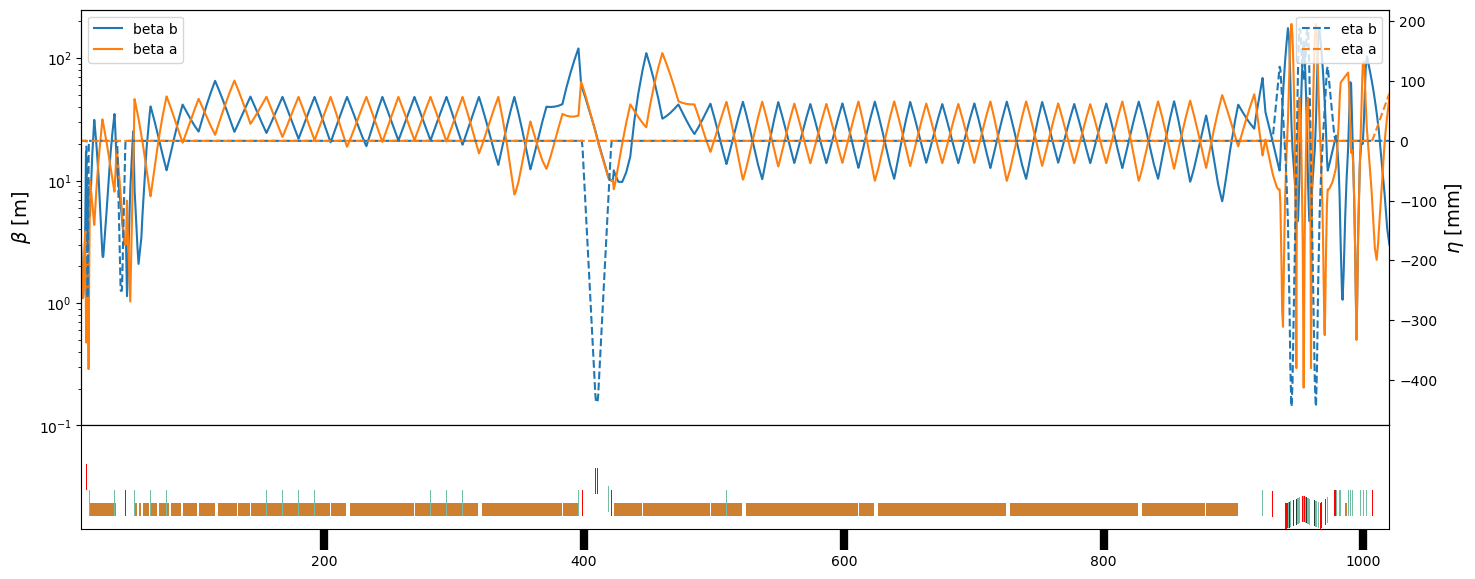

In [11]:
fig = plt.figure(num=1,figsize=[3.375*5,3.375*2])
fig.clf()
ax,ax_fp=format_longitudinal_plot(fig)

ax.semilogy(s,beta_x,label='beta b')
ax.semilogy(s,beta_y,label='beta a')
plt.legend(loc=2)
ax.set_ylim([0.1,250])
ax_r=ax.twinx()
ax_r.plot(s,eta_x*1e3,'C0--',label='eta b')
ax_r.plot(s,eta_y*1e3,'C1--',label='eta a')
plt.legend(loc=1)
#ax_r.plot(s,beta_y,'k--')
#ax_r.plot(s,np.array([tao.lat_list(x,'ele.x.eta')[0] for x in floorplan.Index]),'--')

ax.set_facecolor('w')
zmin=13
zmax=1020

ax.set_xlabel('Z [m]',fontsize=14)
ax.set_ylabel(r'$\beta$ [m]',fontsize=14)
ax_r.set_ylabel(r'$\eta$ [mm]',fontsize=14)

ax.set_xlim([zmin,zmax])
ax_fp.set_ylim([-1,3])

plt.show()
#fig.savefig(savefolder+'beamline'+savestem,transparent=False,bbox_inches='tight')

## Track particles (no csr)

In [12]:
tao.cmd('set beam_init n_particle = 10000') # limit to 10k particles for now

[]

In [13]:
print('Track start: ', tao.beam()['track_start'])
tao.beam_init()['position_file']

Track start:  L0AFEND


'$FACET2_LATTICE/bmad/beams/L0AFEND.h5'

In [23]:
P = ParticleGroup('/u/ar/dcesar/notebooks/facet_bmad/bmad/beams/L0AFEND.h5')
P.data.update(resample_particles(P, n=10000))
P.gamma=P.gamma-np.mean(P.gamma)+tao.lat_list('L0AFEND','ele.e_tot')[0]*1e-6/0.511;
P.twiss_match(plane='y',beta=tao.lat_list('L0AFEND','ele.a.beta'),alpha=tao.lat_list('L0AFEND','ele.a.alpha'),inplace=True)
P.twiss_match(plane='x',beta=tao.lat_list('L0AFEND','ele.b.beta'),alpha=tao.lat_list('L0AFEND','ele.b.alpha'),inplace=True)

print(P.twiss(plane='x'))
print(P.twiss(plane='y'))
P.write('/u/ar/dcesar/notebooks/facet_bmad/bmad/beams/L0AFEND_matched.h5')

{'alpha_x': -7.999911853998102, 'beta_x': 35.99961742649441, 'gamma_x': 1.8055355672725213, 'emit_x': 3.053900073225447e-08, 'eta_x': 0.002803614370651583, 'etap_x': 0.0006342398219775685, 'norm_emit_x': 3.824723575483103e-06}
{'alpha_y': -8.00063558610844, 'beta_y': 36.00353754049107, 'gamma_y': 1.805660616226715, 'emit_y': 3.0418565932798533e-08, 'eta_y': -0.005422169561376792, 'etap_y': -0.0014830895798264548, 'norm_emit_y': 3.8096402457819716e-06}


In [25]:
print('Track start: ', tao.beam()['track_start'])
tao.beam_init()['position_file']

Track start:  L0AFEND


'$FACET2_LATTICE/bmad/beams/L0AFEND.h5'

In [26]:
tao.cmd('set beam_init position_file=$FACET2_LATTICE/bmad/beams/L0AFEND_matched.h5')
tao.cmd('reinit beam')

[]

In [54]:
tao.cmd('csroff') #only works once we define the alias "csroff" in the next section.
tao.cmd('set global track_type = beam') #set "track_type = single" to return to single particle
tao.cmd('set global track_type = single') #return to single to prevent accidental long re-evaluation

[]

In [55]:
bunch_beta_y=np.array([tao.bunch_params(x)['beta_y'] for x in floorplan.Index])
bunch_beta_x=np.array([tao.bunch_params(x)['beta_x'] for x in floorplan.Index])
bunch_etot=np.array([tao.bunch_params(x)['centroid_p0c']*0.511 for x in floorplan.Index])
bunch_eta_y=np.array([tao.bunch_params(x)['eta_y'] for x in floorplan.Index])
bunch_eta_x=np.array([tao.bunch_params(x)['eta_x'] for x in floorplan.Index])

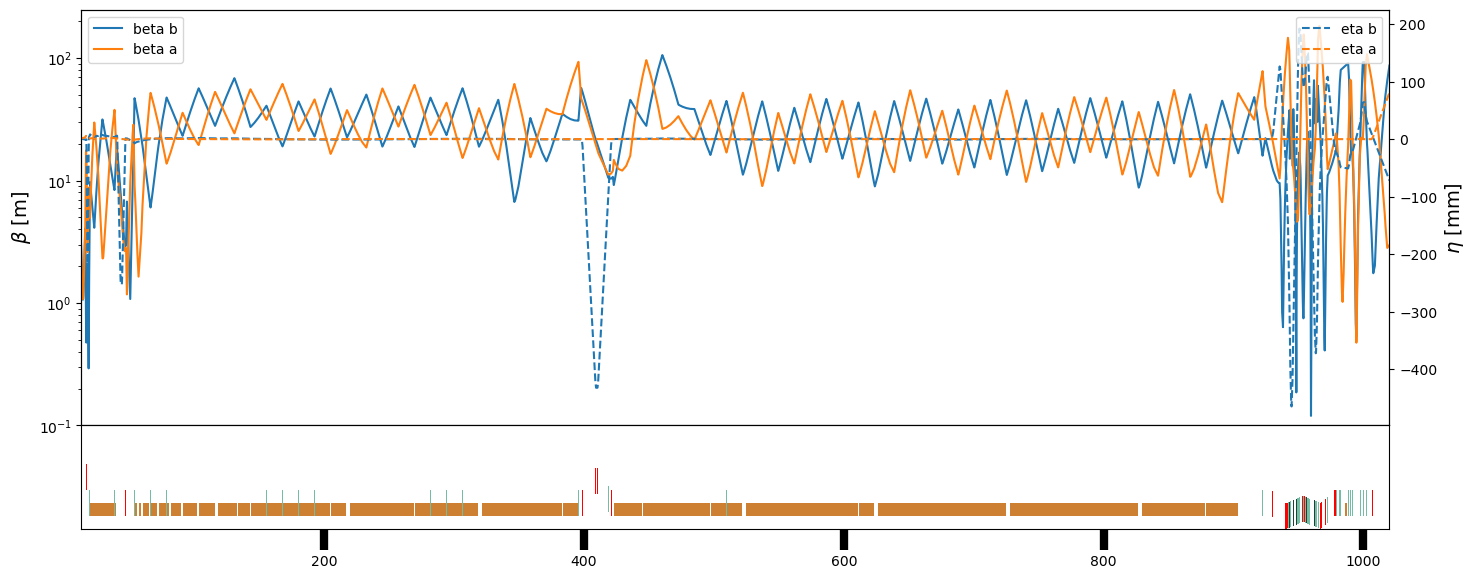

In [56]:
fig = plt.figure(num=1,figsize=[3.375*5,3.375*2])
fig.clf()
ax,ax_fp=format_longitudinal_plot(fig)

ax.semilogy(s,bunch_beta_x,label='beta b')
ax.semilogy(s,bunch_beta_y,label='beta a')
plt.legend(loc=2)
ax.set_ylim([0.1,250])
ax_r=ax.twinx()
ax_r.plot(s,bunch_eta_x*1e3,'C0--',label='eta b')
ax_r.plot(s,bunch_eta_y*1e3,'C1--',label='eta a')
plt.legend(loc=1)
#ax_r.plot(s,beta_y,'k--')
#ax_r.plot(s,np.array([tao.lat_list(x,'ele.x.eta')[0] for x in floorplan.Index]),'--')

ax.set_facecolor('w')
zmin=13
zmax=1020

ax.set_xlabel('Z [m]',fontsize=14)
ax.set_ylabel(r'$\beta$ [m]',fontsize=14)
ax_r.set_ylabel(r'$\eta$ [mm]',fontsize=14)

ax.set_xlim([zmin,zmax])
ax_fp.set_ylim([-1,3])

plt.show()
#fig.savefig(savefolder+'beamline'+savestem,transparent=False,bbox_inches='tight')

In [57]:
P = ParticleGroup(data=tao.bunch_data('MIP'))
# Select out live particles
P = P[P.status==1]
P.drift_to_z()

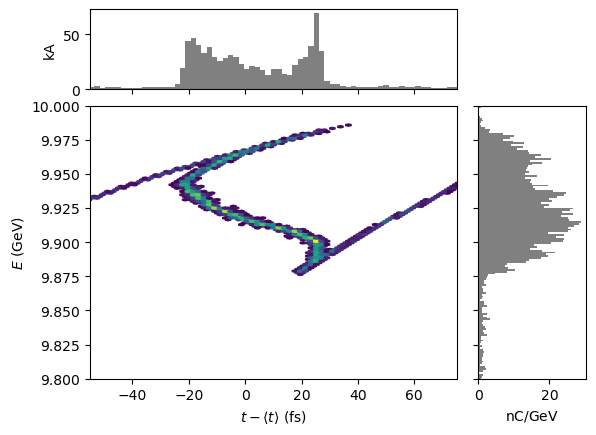

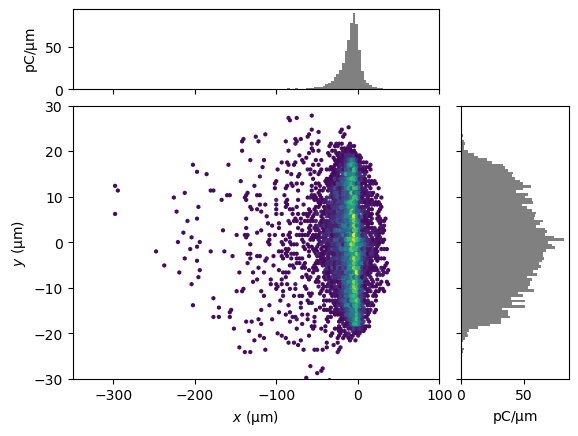

In [58]:
P.plot('delta_t', 'energy',bins=300,xlim=[-55e-15,75e-15],ylim=[9.8e9,10.0e9])
P.plot('x', 'y',bins=100,xlim=[-350e-6,100e-6],ylim=[-30e-6,30e-6])

## Again, with CSR

In [46]:
tao.cmd('call /u/ar/dcesar/notebooks/facet_bmad/bmad/models/f2_elec/scripts/Activate_CSR.tao')

['',
 'Tao: !---Turns on some typical CSR parameters',
 '',
 'Tao: !set global track_type = single',
 '',
 'Tao: set global plot_on = false',
 '',
 'Tao: set global lattice_calc_on=false',
 '',
 'Tao: !---Turn on ISR fluctuations',
 '',
 'Tao: set bmad_com radiation_fluctuations_on = T',
 '',
 'Tao: !---CSR---',
 '',
 'Tao: set csr_param beam_chamber_height = 0.024  ! 24 mm full height',
 '',
 'Tao: set csr_param n_shield_images = 0',
 '',
 'Tao: set csr_param ds_track_step = 0.01',
 '',
 'Tao: set csr_param n_bin = 40',
 '',
 'Tao: set csr_param particle_bin_span = 2',
 '',
 'Tao: set csr_param sigma_cutoff = 0.1 ! Cutoff for the lsc calc. If a bin sigma is < cutoff * sigma_ave then ignore.',
 '',
 'Tao: !---------------------------------------------',
 '',
 'Tao: set global lattice_calc_on=true',
 '',
 'Tao: alias csrstep set csr_param ds_track_step = [[1]]',
 '',
 'Tao: alias csron  set bmad_com csr_and_space_charge_on = T',
 '',
 'Tao: alias csroff set bmad_com csr_and_space_charge

In [47]:
tao.cmd('csron')

[]

In [48]:
tao.cmd('set global track_type = beam')
tao.cmd('set global track_type = single')

[]

In [49]:
P = ParticleGroup(data=tao.bunch_data('MIP'))
# Select out live particles
P = P[P.status==1]
P.drift_to_z()

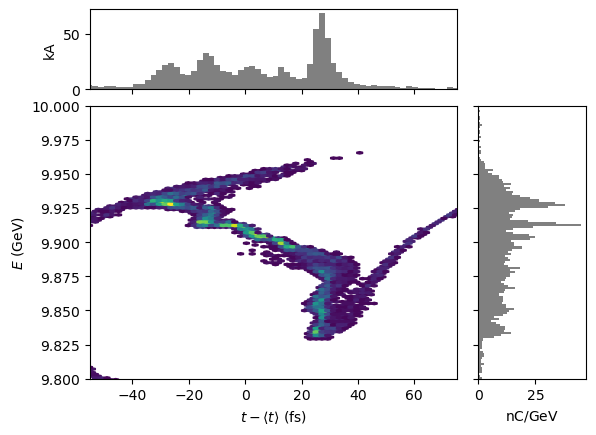

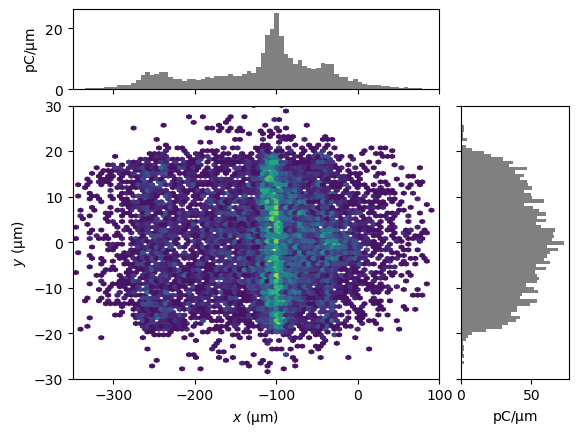

In [53]:
P.plot('delta_t', 'energy',bins=300,xlim=[-55e-15,75e-15],ylim=[9.8e9,10.0e9])
P.plot('x', 'y',bins=100,xlim=[-350e-6,100e-6],ylim=[-30e-6,30e-6])

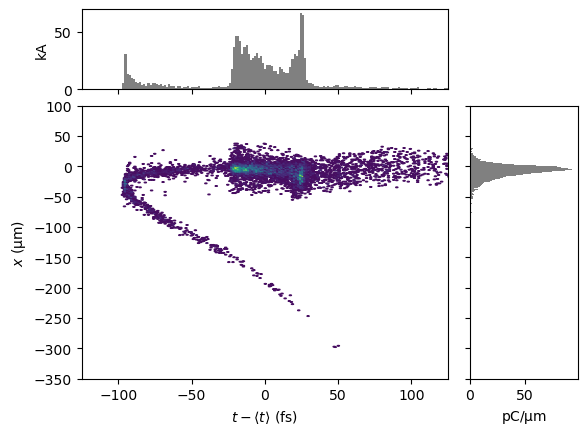

In [66]:
P.plot('delta_t', 'x',bins=400,xlim=[-125e-15,125e-15],ylim=[-350e-6,100e-6])